In [1]:
import uproot
import pandas as pd
import fastjet as fj
import fjcontrib
import fjext
import os
from pyjetty.mputils import perror, pwarning, pinfo, pdebug
from pyjetty.mputils import treewriter
from tqdm.notebook import tqdm
import ROOT

Welcome to JupyROOT 6.22/08


# An example analysis of ALICE data file - in a class

This class hass a few features:
- open an output file in the contructor (define the output - tree in this case) - in the `.init_output()`
- for each file one can call `.analyze_file(<input_file_path>)`
- at the end one has to call `.finish()` to write to the output file properly
- now the analysis is implemented in the `.analyze_event()`

So the short code looks like:
```
an = AnalyzeDataFile('output.root')
an.analyze_file('some_alice_input_file.root')
an.analyze_file('some_other_alice_input_file.root')
...
an.finish()
```

In [2]:
class AnalyzeDataFile(object):
    def __init__(self, output_filename):
        self.event_tree_name = 'PWGHF_TreeCreator/tree_event_char'
        self.track_tree_name = 'PWGHF_TreeCreator/tree_Particle'
        if not self.init_output(output_filename):
            perror('unable to initialize with', output_filename, 'file as output.')
            return
        
    def get_pandas_from_a_file_with_query(self, file_name, tree_name, squery=None):
        try:
            tree = uproot.open(file_name)[tree_name]
        except:
            pwarning('error getting', tree_name, 'from file:', file_name)
            return None
        if not tree:
            perror('tree {} not found in file {}'.format(tree_name, file_name))
            return None
        if uproot.version.version_info[0] == '4':
            df = tree.arrays(library="pd")
        else:
            df = tree.pandas.df()
        if squery:
            #df.query(squery, inplace=True)
            df = df.query(squery)
            df.reset_index(drop=True)
        return df
    
    def analyze_file(self, input_filename):
        if not os.path.isfile(input_filename):
            perror('file', output_filename, 'does not exists.')
            return
        _event_df = self.get_pandas_from_a_file_with_query(input_filename, self.event_tree_name, 'is_ev_rej == 0')
        if _event_df is None:
            perror('unable to continue...')
            return
        _track_df_unmerged = self.get_pandas_from_a_file_with_query(input_filename, self.track_tree_name)
        if _track_df_unmerged is None:
            perror('unable to continue...')
            return
        # Merge event info into track tree
        if 'ev_id_ext' in list(_event_df):
            _track_df = pd.merge(_track_df_unmerged, _event_df, on=['run_number', 'ev_id', 'ev_id_ext'])
        else:
            # older data formats - should not be used
            pwarning('using the old data format - without ev_id_ext ...')
            _track_df = pd.merge(_track_df_unmerged, _event_df, on=['run_number', 'ev_id'])
        # group the track dataframe by event
        # track_df_grouped is a DataFrameGroupBy object with one track dataframe per event
        _track_df_grouped = _track_df.groupby(['run_number','ev_id'])
        # transform -> analyze the "events==dataframes" 
        # use a progress bar
        self.pbar = tqdm(range(len(_track_df_grouped)))
        _ = _track_df_grouped.apply(self.analyze_event)
        self.pbar.close()

    def get_unique_fname(fn):
        counter = 0
        outfn = fn.replace('.root', '_{}.root'.format(counter))
        while os.path.exists(outfn):
            counter += 1
            outfn = fn.replace('.root', '_{}.root'.format(counter))
        return outfn

    def init_output(self, output_filename):
        self.output_filename = output_filename
        self.output_tree = treewriter.RTreeWriter(name = 'jets', file_name = self.output_filename)
        if self.output_tree:
            return True
        return False
        
    def analyze_event(self, df):
        #df here is a merged dataframe from the event and track trees
        self.pbar.update(1)

        #make FastJet PseudoJet vectors from tracks describbed by Pt,Eta,Phi 
        _particles = fjext.vectorize_pt_eta_phi(df['ParticlePt'].values, df['ParticleEta'].values, df['ParticlePhi'].values)

        #define a jet finder on the event
        jet_R0 = 0.4
        jet_definition = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
        # select jets in a pT window and fully contained within ALICE acceptance (eta tracks < 0.9)
        jet_selector = fj.SelectorPtMin(10.0) & fj.SelectorPtMax(1000.0) & fj.SelectorAbsEtaMax(0.9 - jet_R0)
        # get jets == actually run the jet finder
        jets = fj.sorted_by_pt(jet_selector(jet_definition(_particles)))        
        #define a soft drop algorithm
        sd01 = fjcontrib.SoftDrop(0, 0.1, 1.0)
        
        # do something for each jet
        for j in jets:
            # get the jet after soft drop
            j_sd01 = sd01.result(j)
            # get the kinematics of the soft drop selected split
            j_sd01_info = fjcontrib.get_SD_jet_info(j_sd01)
            # stream to the output tree
            self.output_tree.fill_branches( j       = j,
                                            j_sd01  = j_sd01, 
                                            j_sd01_z  = j_sd01_info.z, 
                                            j_sd01_mu = j_sd01_info.mu, 
                                            j_sd01_Rg = j_sd01_info.dR)
            self.output_tree.fill_tree()
            
    def finish(self):
        # need to call to close the output file properly
        self.output_tree.write_and_close()


In [3]:
an_data_file = AnalyzeDataFile('alice_data_analysis_output.root')

[i] new file alice_data_analysis_output.root


In [4]:
fname = '/Users/ploskon/data/alice/LHC18qr/__rstorage__u__alice__LHC18qr__147-148__147__child_1__0019__AnalysisResults.root'
an_data_file.analyze_file(fname)

[w] using the old data format - without ev_id_ext ...


  0%|          | 0/899 [00:00<?, ?it/s]

[i] RTreeWriter jets tree tjets: creating branch [j_pt]
[i] RTreeWriter jets tree tjets: creating branch [j_phi]
[i] RTreeWriter jets tree tjets: creating branch [j_eta]
[i] RTreeWriter jets tree tjets: creating branch [j_m]
[i] RTreeWriter jets tree tjets: creating branch [j_nconst]
[i] RTreeWriter jets tree tjets: creating branch [j_sd01_pt]
[i] RTreeWriter jets tree tjets: creating branch [j_sd01_phi]
[i] RTreeWriter jets tree tjets: creating branch [j_sd01_eta]
[i] RTreeWriter jets tree tjets: creating branch [j_sd01_m]
[i] RTreeWriter jets tree tjets: creating branch [j_sd01_nconst]
[i] RTreeWriter jets tree tjets: creating branch [j_sd01_z]
[i] RTreeWriter jets tree tjets: creating branch [j_sd01_mu]
[i] RTreeWriter jets tree tjets: creating branch [j_sd01_Rg]
#--------------------------------------------------------------------------
#                         FastJet release 3.3.3
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package f

In [5]:
an_data_file.finish()

[i] writing alice_data_analysis_output.root


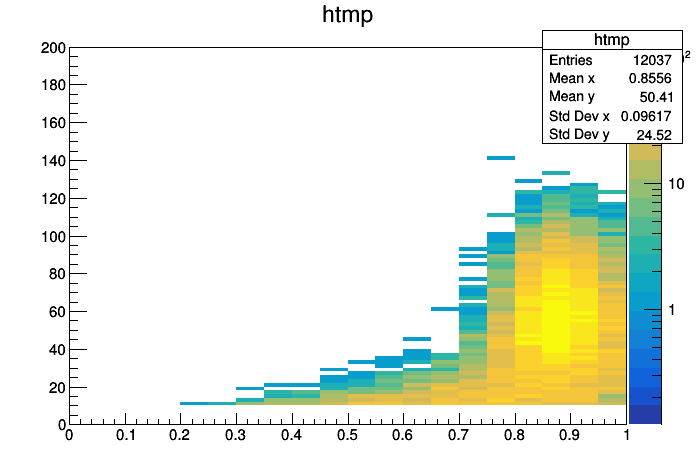

In [6]:
#analyze the output file
# %jsroot on
tc = ROOT.TCanvas('somehist', 'somehist')
tc.cd()
fin = ROOT.TFile('alice_data_analysis_output.root')
tjets = fin.Get('tjets')
htmp = ROOT.TH2F('htmp', 'htmp', 20,0,1,100,0,200)
tjets.Draw('j_pt:j_sd01_Rg/0.4>>htmp')
htmp.Draw('colz')
tc.SetLogz()
tc.Draw()